In [1]:
import os,sys
import pathlib
project_path = pathlib.Path('~/repositories/herg')
project_path = project_path.expanduser()
code_dir = project_path / 'common'
sys.path.insert(0, str(code_dir))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from molvs import Standardizer
from miscellaneous import *
from predict_functions import *
from descriptor_setup import dnames, dlist
from statistics import mean, stdev
from build_functions import MSE,R2,RMSE


## 50 models
# random_splits = [42, 77, 301, 212, 617, 781, 505, 22, 365, 993, \
#                  925, 983, 649, 140, 527, 815, 573, 142, 556, 800, \
#                  652, 965, 933, 284, 135, 81, 872, 943, 541, 76, \
#                  139, 976, 600, 125, 679, 728, 764, 969, 334, 449,\
#                  623, 229, 864, 239, 873, 549, 215, 791, 716, 11]



## 
## random_splits = [42, 77]
random_splits = [42]

## testing dataset
data_dir="/home/khlee/cheminformatics/screening/data"
basefile = "testset_pairs"


In [2]:

##  hERG regression model

## the model used for prediction
model_dir="/home/khlee/cheminformatics/hERG/regression_1.00"
result_list = []

for random_split in random_splits:
    #print("split: ", random_split)
    input_data = read_mols(basefile, random_split,datadir=data_dir,modeldir=model_dir)
    molnames = input_data['molnames']
    molecules = input_data['molecules']
    model = input_data['model']
    inds = input_data['inds']
    sigbits = input_data['sigbits']
    ad_fps = input_data['ad_fps']
    ad_radius = input_data['ad_radius']
    # Check Applicability Domain
    appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames)
    molecules = appdom_results['test_mols']
    molnames = appdom_results['test_names']
    molecules_rej = appdom_results['rej_mols']
    molnames_rej = appdom_results['rej_names']
    topo_descriptors = calc_topo_descs(molecules, inds)
    phore_descriptors = calc_phore_descs(molecules, sigbits)
    # Combine all selected descriptors into one matrix
    descriptors = np.concatenate((topo_descriptors, phore_descriptors), axis=1)
    pred_results = make_preds(molnames, descriptors, model, random_split)
    results = pred_results['predictions']
    result_list.append(results)

## final results
hERG_compound, hERG_pred, hERG_pred_error=summarize_preds(molnames, result_list)



##  hDAT regression model
#model_dir="/home/khlee/cheminformatics/DAT/regression_1.00"
model_dir="/home/khlee/cheminformatics/DAT/aDAT_regression_100"
# model_dir="/home/khlee/cheminformatics/DAT/hDAT_regression_100"
# model_dir="/home/khlee/cheminformatics/DAT/rDAT_regression_100"

result_list = []

for random_split in random_splits:
    #print("split: ", random_split)
    input_data = read_mols(basefile, random_split,datadir=data_dir,modeldir=model_dir)
    molnames = input_data['molnames']
    molecules = input_data['molecules']
    model = input_data['model']
    inds = input_data['inds']
    sigbits = input_data['sigbits']
    ad_fps = input_data['ad_fps']
    ad_radius = input_data['ad_radius']
    # Check Applicability Domain
    appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames)
    molecules = appdom_results['test_mols']
    molnames = appdom_results['test_names']
    molecules_rej = appdom_results['rej_mols']
    molnames_rej = appdom_results['rej_names']
    topo_descriptors = calc_topo_descs(molecules, inds)
    phore_descriptors = calc_phore_descs(molecules, sigbits)
    # Combine all selected descriptors into one matrix
    descriptors = np.concatenate((topo_descriptors, phore_descriptors), axis=1)
    pred_results = make_preds(molnames, descriptors, model, random_split)
    results = pred_results['predictions']
    result_list.append(results)

## final results
hDAT_compound, hDAT_pred, hDAT_pred_error=summarize_preds(molnames, result_list)


setting modeldir to  /home/khlee/cheminformatics/hERG/regression_1.00 .
Have you set the random splits to be correct for the model?
No molecules rejected for prediction by AD
significant_bits: 1917
fp_descriptors: (19, 1917)
Summary Results
Compound	Predicted	StdDev
Modafinil 	 4.734 	 0.000
JBG1-48 	 4.469 	 0.000
JBG2-54 	 6.364 	 0.000
JBG2-56 	 5.868 	 0.000
JJC8-016 	 7.006 	 0.000
JJC8-088 	 6.846 	 0.000
JJC8-089 	 6.536 	 0.000
JJC8-091 	 5.327 	 0.000
RDS03-094 	 6.402 	 0.000
RDS04-010 	 5.473 	 0.000
RDS04-011 	 6.808 	 0.000
TCK-1-49 	 6.643 	 0.000
TCK-1-74 	 5.784 	 0.000
TCK-1-76 	 6.005 	 0.000
TCK-2-22 	 5.714 	 0.000
TCK-2-34 	 5.448 	 0.000
TCK-2-40 	 5.519 	 0.000
TCK-2-43 	 5.659 	 0.000
TCK-2-80 	 5.287 	 0.000
setting modeldir to  /home/khlee/cheminformatics/DAT/aDAT_regression_100 .
Have you set the random splits to be correct for the model?
No molecules rejected for prediction by AD
significant_bits: 471
fp_descriptors: (19, 471)
Summary Results
Compound	Predic

In [3]:
from runmodel import read_mols, calc_descs, make_preds, check_appdom

## hERG classifier
model_dir="/home/khlee/cheminformatics/hERG/classifier_1.00"

ls_predictions = []

for random_split in random_splits:
    print(random_split)
    model_data = read_mols(basefile, random_split, 301,datadir=data_dir,modeldir=model_dir)
    molnames = model_data['molnames']
    molecules = model_data['molecules']
    model = model_data['model']
    inds = model_data['inds']
    ad_fps = model_data['ad_fps']
    ad_radius = model_data['ad_radius']
    # scheme A, know activity
    #activities = model_data['activities']
    #appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames, activities)
    #test_mols = appdom_results['test_mols']
    #test_names = appdom_results['test_names']
    #rej_mols = appdom_results['rej_mols']
    #rej_names = appdom_results['rej_names']
    #test_acts = appdom_results['test_acts']
    #rej_acts = appdom_results['rej_acts']
    # end scheme A
    # scheme B, unknow activity
    appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames)
    test_mols = appdom_results['test_mols']
    test_names = appdom_results['test_names']
    rej_mols = appdom_results['rej_mols']
    rej_names = appdom_results['rej_names'] 
    # end scheme B
    descriptors = calc_descs(test_mols, inds)
    #A = make_preds(test_names, descriptors, model, test_acts)
    A=make_preds(test_names, descriptors, model)
    #ls_accuracy.append(A['accuracy'])
    ls_predictions.append(A['predictions'])

hERG_classifier = ls_predictions




## hDAT classifier
model_dir="/home/khlee/cheminformatics/DAT/classifier_1.00"

ls_predictions = []

for random_split in random_splits:
    print(random_split)
    model_data = read_mols(basefile, random_split, 301,datadir=data_dir,modeldir=model_dir)
    molnames = model_data['molnames']
    molecules = model_data['molecules']
    model = model_data['model']
    inds = model_data['inds']
    ad_fps = model_data['ad_fps']
    ad_radius = model_data['ad_radius']
    # scheme A, know activity
    #activities = model_data['activities']
    #appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames, activities)
    #test_mols = appdom_results['test_mols']
    #test_names = appdom_results['test_names']
    #rej_mols = appdom_results['rej_mols']
    #rej_names = appdom_results['rej_names']
    #test_acts = appdom_results['test_acts']
    #rej_acts = appdom_results['rej_acts']
    # end scheme A
    # scheme B, unknow activity
    appdom_results = check_appdom(ad_fps, ad_radius, molecules, molnames)
    test_mols = appdom_results['test_mols']
    test_names = appdom_results['test_names']
    rej_mols = appdom_results['rej_mols']
    rej_names = appdom_results['rej_names'] 
    # end scheme B
    descriptors = calc_descs(test_mols, inds)
    #A = make_preds(test_names, descriptors, model, test_acts)
    A=make_preds(test_names, descriptors, model)
    #ls_accuracy.append(A['accuracy'])
    ls_predictions.append(A['predictions'])

hDAT_classifier = ls_predictions

42
setting modeldir to  /home/khlee/cheminformatics/hERG/classifier_1.00 .
Have you set the random splits to be correct for the model?


/share/apps/python/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/share/apps/python/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


No molecules rejected for prediction by AD
Molecule	Predicted Act.
Modafinil 	 0
JBG1-48 	 0
JBG2-54 	 1
JBG2-56 	 1
JJC8-016 	 1
JJC8-088 	 1
JJC8-089 	 1
JJC8-091 	 1
RDS03-094 	 1
RDS04-010 	 1
RDS04-011 	 1
TCK-1-49 	 1
TCK-1-74 	 1
TCK-1-76 	 1
TCK-2-22 	 1
TCK-2-34 	 1
TCK-2-40 	 1
TCK-2-43 	 1
TCK-2-80 	 1
42
setting modeldir to  /home/khlee/cheminformatics/DAT/classifier_1.00 .
Have you set the random splits to be correct for the model?


/share/apps/python/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/share/apps/python/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


No molecules rejected for prediction by AD
Molecule	Predicted Act.
Modafinil 	 0
JBG1-48 	 0
JBG2-54 	 1
JBG2-56 	 1
JJC8-016 	 1
JJC8-088 	 1
JJC8-089 	 1
JJC8-091 	 1
RDS03-094 	 1
RDS04-010 	 1
RDS04-011 	 1
TCK-1-49 	 1
TCK-1-74 	 1
TCK-1-76 	 1
TCK-2-22 	 1
TCK-2-34 	 1
TCK-2-40 	 1
TCK-2-43 	 1
TCK-2-80 	 1


In [4]:
## summary
for icompound in range(len(test_names)):
    isum_hERG=0
    isum_hDAT=0
    for i in range(len(random_splits)):
        isum_hERG=isum_hERG + hERG_classifier[i][icompound]
        isum_hDAT=isum_hDAT + hDAT_classifier[i][icompound]
       # print(hERG_classifier[i][0],isum)
    print(test_names[icompound],\
          isum_hERG,\
          hERG_compound[icompound], \
          hERG_pred[icompound], \
          hERG_pred_error[icompound],\
          test_names[icompound],\
          isum_hDAT,\
          hDAT_compound[icompound], \
          hDAT_pred[icompound], \
          hDAT_pred_error[icompound])
    

Modafinil 0 Modafinil 4.7338486 0.0 Modafinil 0 Modafinil 5.8226485 0.0
JBG1-48 0 JBG1-48 4.4688573 0.0 JBG1-48 0 JBG1-48 5.444496 0.0
JBG2-54 1 JBG2-54 6.363579 0.0 JBG2-54 1 JBG2-54 7.4106946 0.0
JBG2-56 1 JBG2-56 5.8681135 0.0 JBG2-56 1 JBG2-56 5.909403 0.0
JJC8-016 1 JJC8-016 7.0057235 0.0 JJC8-016 1 JJC8-016 6.372788 0.0
JJC8-088 1 JJC8-088 6.8461103 0.0 JJC8-088 1 JJC8-088 7.441824 0.0
JJC8-089 1 JJC8-089 6.5360265 0.0 JJC8-089 1 JJC8-089 7.57096 0.0
JJC8-091 1 JJC8-091 5.3268733 0.0 JJC8-091 1 JJC8-091 7.31057 0.0
RDS03-094 1 RDS03-094 6.401981 0.0 RDS03-094 1 RDS03-094 7.811588 0.0
RDS04-010 1 RDS04-010 5.4729996 0.0 RDS04-010 1 RDS04-010 6.724477 0.0
RDS04-011 1 RDS04-011 6.808164 0.0 RDS04-011 1 RDS04-011 7.17353 0.0
TCK-1-49 1 TCK-1-49 6.64338 0.0 TCK-1-49 1 TCK-1-49 6.8988657 0.0
TCK-1-74 1 TCK-1-74 5.7836075 0.0 TCK-1-74 1 TCK-1-74 6.65018 0.0
TCK-1-76 1 TCK-1-76 6.004908 0.0 TCK-1-76 1 TCK-1-76 6.826335 0.0
TCK-2-22 1 TCK-2-22 5.7136908 0.0 TCK-2-22 1 TCK-2-22 6.360771 0.

In [5]:
## read exp

f = open(data_dir+'/testset_pairs_hDAT.act','r')
lines=f.read().split('\n')
f.close()
hDAT_idx=[]
hDAT_act=[]
hDAT_act_error=[]
for line in lines:
    if not line=='':
        hDAT_idx.append(line.split()[0])
        hDAT_act.append(float(line.split()[1]))
        hDAT_act_error.append(float(line.split()[2]))


f = open(data_dir+'/testset_pairs_hERG.act','r')
lines=f.read().split('\n')
f.close()
hERG_idx=[]
hERG_act=[]
hERG_act_error=[]
for line in lines:
    if not line=='':
        hERG_idx.append(line.split()[0])
        hERG_act.append(float(line.split()[1]))
        hERG_act_error.append(float(line.split()[2]))



Populating the interactive namespace from numpy and matplotlib


/share/apps/python/anaconda3-2020.02/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.05, '100% Traning Data')

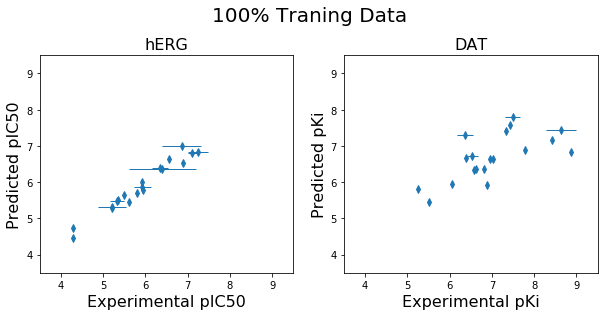

In [6]:
#%matplotlib inline
%pylab inline

# figure parameters
nrow=1
ncol=2
figheight=4
figwidth=10
linewidth=1
maxylim=8


fig, (ax1, ax2) = plt.subplots(nrow, ncol,figsize=(figwidth,figheight))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=1.5)

    
## hERG; c25
x=hERG_act
y=hERG_pred
xerr=hERG_pred_error
yerr=hERG_act_error
ax1.errorbar(x, y, xerr, yerr, fmt='d',markersize='5',elinewidth=1)
ax1.set_xlabel('Experimental pIC50', fontsize=16)
ax1.set_ylabel('Predicted pIC50', fontsize=16)
ax1.set_xlim(3.5, 9.5)
ax1.set_ylim(3.5, 9.5)
ax1.set_title('hERG', fontsize=16)


## hDAT; c25
x=hDAT_act
y=hDAT_pred
xerr=hDAT_pred_error
yerr=hDAT_act_error
ax2.errorbar(x, y, xerr, yerr, fmt='d',markersize='5',elinewidth=1)
ax2.set_xlabel('Experimental pKi', fontsize=16)
ax2.set_ylabel('Predicted pKi', fontsize=16)
ax2.set_xlim(3.5, 9.5)
ax2.set_ylim(3.5, 9.5)
ax2.set_title('DAT', fontsize=16)

fig.suptitle('100% Traning Data', y=1.05, fontsize=20)


In [10]:
## https://kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python

def r2_np(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return(r_squared)


print("\n\nUsing NumPy fucntion (R^2)")
print("R2(np)   hERG act/pred: ",r2_np(hERG_act,hERG_pred))
print("R2(np)   hERG pred/act: ",r2_np(hERG_pred,hERG_act))
print("R2(np)   hDAT act/pred: ",r2_np(hDAT_act,hDAT_pred))
print("R2(np)   hDAT pred/act: ",r2_np(hDAT_pred,hDAT_act))



Using NumPy fucntion (R^2)
R2(np)   hERG act/pred:  0.9591487316000065
R2(np)   hERG pred/act:  0.9591487316000065
R2(np)   hDAT act/pred:  0.44752317838371614
R2(np)   hDAT pred/act:  0.44752317838371614


In [11]:
def r_np(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    #r_squared = correlation_xy**2
    return(correlation_xy)


print("\n\nUsing NumPy fucntion (R)")
print("R2(np)   hERG act/pred: ",r_np(hERG_act,hERG_pred))
print("R2(np)   hERG pred/act: ",r_np(hERG_pred,hERG_act))
print("R2(np)   hDAT act/pred: ",r_np(hDAT_act,hDAT_pred))
print("R2(np)   hDAT pred/act: ",r_np(hDAT_pred,hDAT_act))





Using NumPy fucntion (R)
R2(np)   hERG act/pred:  0.9793613896820756
R2(np)   hERG pred/act:  0.9793613896820756
R2(np)   hDAT act/pred:  0.6689717321260414
R2(np)   hDAT pred/act:  0.6689717321260414


In [7]:
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error, make_scorer, accuracy_score


In [8]:
r2_score(hERG_act,hERG_pred)

0.9386573963399405

In [11]:
#r2_score(hERG_pred,hERG_act)

In [9]:
r2_score(hDAT_act,hDAT_pred)

0.3488354049234208

In [13]:
#r2_score(hDAT_pred,hDAT_act)